# Predicting CSs for peptide binding to the bradykinin 1A receptor

### Analysis and Visualization of NMR Data

This Jupyter Notebook performs analysis and visualization of NMR (Nuclear Magnetic Resonance) data for the section "Predicting CSs for peptide binding to the bradykinin 1A receptor" supplementary figure S1. The workflow includes reading experimental and computational chemical shift (CS) files, generating 2D grids of coordinates, computing correlations, and plotting the results. The code is adapted for prolines (PRO8).

The code functionalities include:

1. **Reading data from Experimental CS Files**: Extract F1 and F2 ranges, number of rows, and columns from a text file.

2. **Generating 2D Grids**: Create a 2D grid of coordinates based on the extracted experimental ranges and dimensions.

3. **Convert NMR data to intensities**: Read intensity values from a file, and reduce the noise from the experimental background signal.

4. **Reading Computational CS Files**: Read data from CSV files, store in a dictionary with combined keys, and convert values to floats.

5. **Computing DQ-SQ Correlations**: Mimic the correlations between neighbourg atoms as DQ-SQ Data.

6. **Plotting DQ-SQ Data**: Plot the DQ-SQ data, and saving the plot as an image file.


### Load modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

### Load Functions

In [4]:
def read_experimental_CS_file(file_path):
    """
    Reads a text file containing metadata information and extracts F1 and F2 ranges,
    as well as the number of rows and columns.

    Parameters:
    - file_path (str): Path to the input text file.

    Returns:
    tuple: Tuple containing F1 left, F1 right, F2 left, F2 right, nrows, and ncols.
    """
    # Initialize variables to None
    f1_left = f1_right = f2_left = f2_right = nrows = ncols = None

    # Open and read the file
    with open(file_path, 'r') as file:
        # Iterate through each line in the file
        for line in file:
            # Check if the line contains information about F1 left and right
            if line.startswith("# F1LEFT"):
                f1_left = float(line.split('=')[1].split(' ')[1])
                f1_right = float(line.split('=')[2].split(' ')[1])
            # Check if the line contains information about F2 left and right
            elif line.startswith("# F2LEFT"):
                f2_left = float(line.split('=')[1].split(' ')[1])
                f2_right = float(line.split('=')[2].split(' ')[1])
            # Check if the line contains information about the number of rows
            elif line.startswith("# NROWS"):
                nrows = int(line.split('=')[1].split(' ')[1])
            # Check if the line contains information about the number of columns
            elif line.startswith("# NCOLS"):
                ncols = int(line.split('=')[1].split(' ')[1])

    # Return the extracted values as a tuple
    return f1_left, f1_right, f2_left, f2_right, nrows, ncols


def generate_grid(f1_left, f1_right, f2_left, f2_right, nrows, ncols):
    """
    Generates a 2D grid of coordinates based on the provided F1 and F2 ranges,
    along with the specified number of rows and columns.

    Parameters:
    - f1_left (float): Left boundary of F1 axis.
    - f1_right (float): Right boundary of F1 axis.
    - f2_left (float): Left boundary of F2 axis.
    - f2_right (float): Right boundary of F2 axis.
    - nrows (int): Number of rows in the grid.
    - ncols (int): Number of columns in the grid.

    Returns:
    tuple: Tuple containing F1 grid and F2 grid.
    """
    # Generate F1 axis using linspace based on provided boundaries and number of columns
    f1_axis = np.linspace(f1_left, f1_right, ncols)
    
    # Generate F2 axis using linspace based on provided boundaries and number of rows
    f2_axis = np.linspace(f2_left, f2_right, nrows)
    
    # Create a 2D grid using meshgrid for F1 and F2 axes
    f1_grid, f2_grid = np.meshgrid(f1_axis, f2_axis)
    
    # Return the generated F1 and F2 grids as a tuple
    return f1_grid, f2_grid


def read_intensity_values(file_path, nrows, ncols):
    """
    Reads intensity values from a file and stores them in a 2D array.
    Intensity values less than or equal to 7500 are replaced with 7500.

    Parameters:
    - file_path (str): Path to the input intensity values file.
    - nrows (int): Number of rows in the intensity grid.
    - ncols (int): Number of columns in the intensity grid.

    Returns:
    numpy.ndarray: 2D array containing intensity values.
    """
    # Initialize a 2D array to store intensity values
    intensity_values = np.zeros((nrows, ncols))

    # Open and read the file
    with open(file_path, 'r') as file:
        current_row = -1  # Initialize row index
        temp_marker = 0  # Initialize column index within the current row
        for line in file:
            # Check if the line indicates the start of a new row
            if line.startswith("# row"):
                current_row += 1  # Move to the next row
                temp_marker = 0  # Reset column index within the new row
            elif current_row >= 0 and current_row < nrows:
                # Read intensity values and store in the array
                if float(line) <= 7500:
                    intensity_values[current_row, temp_marker] = 7500
                    temp_marker += 1
                else:
                    intensity_values[current_row, temp_marker] = float(line)
                    temp_marker += 1

    # Return the 2D array containing intensity values
    return intensity_values

def read_computational_CS_file(file_path):
    """
    Reads data from a CSV file, creates a dictionary with combined keys,
    and converts values to floats.

    Parameters:
    - file_path (str): Path to the input CSV file.

    Returns:
    dict: Dictionary with combined keys and corresponding float values.
    """
    # Initialize an empty dictionary to store data
    data_dict = {}

    # Open and read the CSV file
    with open(file_path, 'r') as file:
        # Use CSV reader with ';' as the delimiter
        csv_reader = csv.reader(file, delimiter=';')
        
        # Iterate through each row in the CSV file
        for row in csv_reader:
            # Check if the row has at least two elements
            if len(row) >= 2:
                # Combine the first two elements as the key
                key = f"{row[0]}_{row[1]}"
                
                # Replace commas with points and convert the remaining values to floats
                values = [float(value.replace(',', '.')) for value in row[4:-1]]
                
                # Add the key-value pair to the dictionary
                data_dict[key] = values

    # Return the dictionary containing combined keys and float values
    return data_dict

def compute_DQ_SQ(input_dict, key1, key2):
    """
    Sums corresponding values in two lists from a dictionary based on provided keys.

    Parameters:
    - input_dict (dict): Dictionary containing lists as values.
    - key1 (str): First key for the list in the dictionary.
    - key2 (str): Second key for the list in the dictionary.

    Returns:
    list or None: List containing summed values or None if keys are not found.
    """
    # Check if both keys exist in the dictionary
    if key1 in input_dict and key2 in input_dict:
        # Retrieve the lists associated with the provided keys
        list1 = input_dict[key1]
        list2 = input_dict[key2]

        # Sum corresponding values in the lists
        summed_list = [val1 + val2 for val1, val2 in zip(list1, list2)]
        
        # Return the summed list
        return summed_list
    else:
        # Print an error message if one or both keys are not found
        print(f"One or both of the keys '{key1}' and '{key2}' not found in the dictionary.")
        
        # Return None as an indication of failure
        return None
    
def plot_dq_sq(input_file, output_file):
    """
    Visualizes the analysis of the 2D double quantum-single quantum (DQ-SQ) correlation for the Pro8 residue in a protein structure.

    Args:
    input_file (str): Path to the input file containing computational CS data.
    output_file (str): Path to save the generated plot.

    Returns:
    None
    """
    
    # Read computational data for replicate 1
    rep = read_computational_CS_file(input_file)
    
    # Extract data for specific atoms
    C_8 = rep['8_C']
    CA_8 = rep['8_CA']
    CB_8 = rep['8_CB']
    CD_8 = rep['8_CD']
    CG_8 = rep['8_CG']

    # Compute correlation DQ-SQ
    C_CA_8_corr = compute_DQ_SQ(rep, '8_C', '8_CA')
    CA_CB_8_corr = compute_DQ_SQ(rep, '8_CA', '8_CB')
    CB_CD_8_corr = compute_DQ_SQ(rep, '8_CB', '8_CD')
    CB_CG_8_corr = compute_DQ_SQ(rep, '8_CB', '8_CG')
    CD_CG_8_corr = compute_DQ_SQ(rep, '8_CD', '8_CG')

    # Calculate means for each variable
    mean_C_8 = np.mean(C_8)
    mean_CA_8 = np.mean(CA_8)
    mean_CB_8 = np.mean(CB_8)
    mean_CD_8 = np.mean(CD_8)
    mean_CG_8 = np.mean(CG_8)

    mean_C_CA_8_corr = np.mean(C_CA_8_corr)
    mean_CA_CB_8_corr = np.mean(CA_CB_8_corr)
    mean_CB_CD_8_corr = np.mean(CB_CD_8_corr)
    mean_CB_CG_8_corr = np.mean(CB_CG_8_corr)
    mean_CD_CG_8_corr = np.mean(CD_CG_8_corr)

    # Plotting
    plt.figure(figsize=(15, 6))

    # Scatter plot for the existing intensity values
    plt.scatter(*zip(*flipped_coordinates), c=intensities, cmap='Greys', marker='.', s=50, zorder=1)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

    # Plotting lines between mean values
    plt.plot([mean_C_8, mean_CA_8], [mean_C_CA_8_corr, mean_C_CA_8_corr], color='black', zorder=1, linewidth=5)
    plt.plot([mean_CA_8, mean_CB_8], [mean_CA_CB_8_corr, mean_CA_CB_8_corr], color='black', zorder=1, linewidth=5)
    plt.plot([mean_CA_8, mean_CA_8], [mean_C_CA_8_corr, mean_CA_CB_8_corr], color='black', zorder=1)
    plt.plot([mean_CB_8, mean_CB_8], [mean_CB_CG_8_corr, mean_CA_CB_8_corr], color='black', zorder=1)
    plt.plot([mean_CG_8, mean_CG_8], [mean_CD_CG_8_corr, mean_CB_CG_8_corr], color='black', zorder=1)
    plt.plot([mean_CG_8, mean_CD_8], [mean_CD_CG_8_corr, mean_CD_CG_8_corr], color='black', zorder=1)
    plt.plot([mean_CB_8, mean_CG_8], [mean_CB_CG_8_corr, mean_CB_CG_8_corr], color='black', zorder=1)

    # Add text labels to specific coordinates
    plt.text(mean_CA_8 + 5, mean_C_CA_8_corr - 5, 'P8 C$\\alpha$', fontsize=20, ha='right')
    plt.text(mean_CB_8 - 5, mean_CA_CB_8_corr + 5, 'P8 C$\\beta$', fontsize=20)
    plt.text(mean_CD_8 + 5, mean_CD_CG_8_corr - 5, 'P8 C$\\delta$', fontsize=20)
    plt.text(mean_CG_8 - 5, mean_CB_CG_8_corr + 5, 'P8 C$\\gamma$', fontsize=20)
    plt.text(mean_C_8 - 5, mean_C_CA_8_corr - 5, 'P8 C', fontsize=20)

    # Scatter plots for additional distributions
    plt.scatter(C_8, C_CA_8_corr, c='grey', marker='o', s=50, label='DQ-SQ C vs CA', zorder=2)
    plt.scatter(CA_8, C_CA_8_corr, c='red', marker='o', s=50, label='DQ-SQ CA vs C', zorder=2)
    plt.scatter(CA_8, CA_CB_8_corr, c='blue', marker='o', s=50, label='DQ-SQ CA vs CB')
    plt.scatter(CB_8, CA_CB_8_corr, c='green', marker='o', s=50, label='DQ-SQ CB vs CA')
    plt.scatter(CB_8, CB_CG_8_corr, c='mediumpurple', marker='o', s=50, label='DQ-SQ CB vs CG')
    plt.scatter(CD_8, CD_CG_8_corr, c='brown', marker='o', s=50, label='DQ-SQ CD vs CG')
    plt.scatter(CG_8, CD_CG_8_corr, c='cyan', marker='o', s=50, label='DQ-SQ CG vs CD')
    plt.scatter(CG_8, CB_CG_8_corr, c='gold', marker='o', s=50, label='DQ-SQ CG vs CB')

    # Plot details
    plt.xlabel('$\\delta$($^{13}$C) [ppm]', fontsize=22)
    plt.ylabel('$\\delta$$_{DQ}$($^{13}$C) [ppm]', fontsize=22)
    plt.title('2D $^{13}$C-$^{13}$C DQ-SQ of P8', fontsize=26)
    plt.legend(loc='upper left', fontsize=14)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)

    plt.savefig(output_file, dpi=600, bbox_inches='tight')
    plt.show()

### Data Preparation: Reading Experimental Chemical Shifts and Intensity Values

This section prepares the experimental chemical shift (CS) data along with intensity values for further analysis.

1. **Reading Experimental CS Data:** The `read_experimental_CS_file` function is utilized to read the experimental CS data from the file specified by `file_path`. This function returns the boundaries (`f1_left`, `f1_right`, `f2_left`, `f2_right`), number of rows (`nrows`), and number of columns (`ncols`) of the data grid.

2. **Generating Intensity Values:** The `read_intensity_values` function is employed to generate intensity values based on the provided CS data and grid dimensions (`nrows`, `ncols`).

3. **Creating a Grid:** The `generate_grid` function is used to create a grid based on the boundaries obtained from the CS data.

4. **Organizing Data into a Dictionary:** A dictionary (`grid_dict`) is created, where the coordinates serve as keys and the intensity values as values.

5. **Extracting Coordinates and Intensity Values:** Finally, the coordinates and intensity values are extracted from the dictionary for further processing and visualization.


In [3]:
# Example usage
file_path = 'Experimental_data/BradReceptor_20141126.txt'
f1_left, f1_right, f2_left, f2_right, nrows, ncols = read_experimental_CS_file(file_path)

# Generate random intensity values (replace this with your actual intensity values)
intensity_values = read_intensity_values(file_path, nrows, ncols)

# Generate grid
f1_grid, f2_grid = generate_grid(f2_left, f2_right, f1_left, f1_right, nrows, ncols)

# Create a dictionary with coordinates as keys and intensity values as values
grid_dict = {(f2_grid[i, j], f1_grid[i, j]): intensity_values[i, j] for i in range(nrows) for j in range(ncols)}

# Extract coordinates and intensity values from the dictionary
coordinates = list(grid_dict.keys())
flipped_coordinates = [(y, x) for x, y in coordinates]  # Flip the order of coordinates
intensities = list(grid_dict.values())

### Plotting 2D $^{13}$C-$^{13}$C DQ-SQ of Pro8

This section of the Jupyter Notebook cell involves plotting the two-dimensional (2D) $^{13}$C-$^{13}$C DQ-SQ (double-quantum-single-quantum) of Pro8, combining the experimental data and the computational data.

1. **Input Data:** The function `plot_dq_sq` is called with the input file path `'Computational_data/CS_peptide_7EIB_1.csv'` containing computational chemical shift (CS) data for replicate 1 of Pro8. The output file path `'DQ-SQ_pro8_replicate1.png'` specifies the filename for the resulting plot.

2. **Data Processing:** The function reads the computational CS data for Pro8 replicate 1 and calculates correlation coefficients between different atom pairs. It overlapps them in the previously generated grid from experimental NMR.

3. **Plotting:** Lines between mean values are plotted to indicate correlations. Text labels are added to denote specific atom types and positions. Black areas show the experimental obtained spectra, and colored areas represent the computational predictions.

4. **Output:** The resulting plot is saved as `'DQ-SQ_pro8_replicate1.png'` 



#### Replicate 1

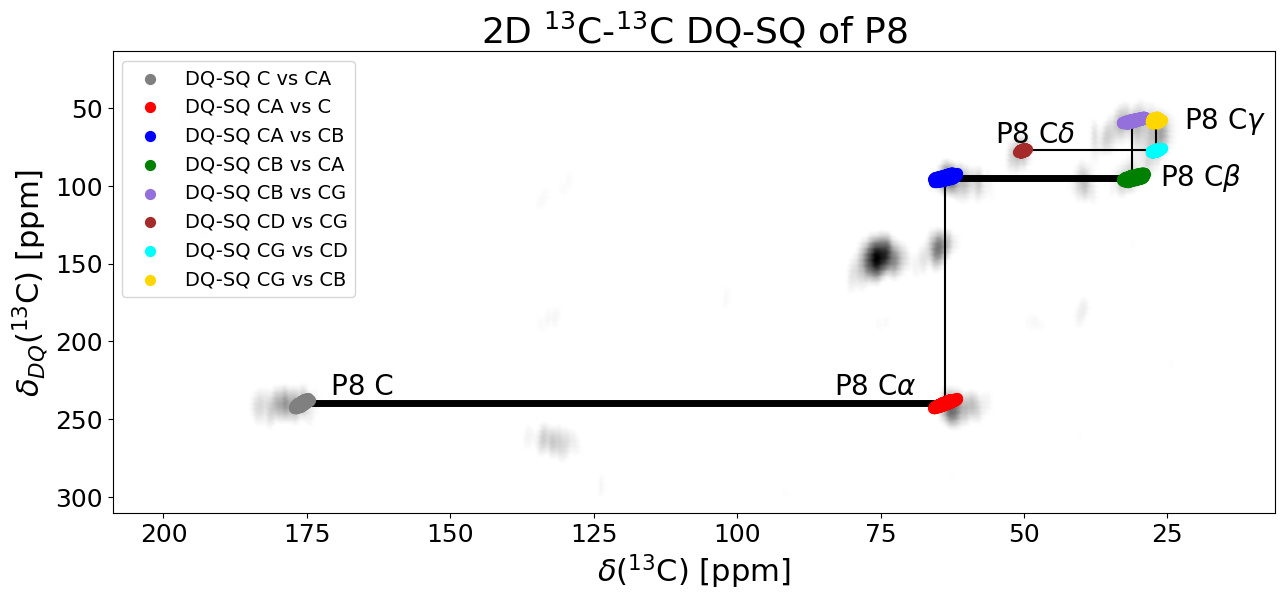

In [5]:
plot_dq_sq('Computational_data/CS_peptide_7EIB_1.csv','plots/DQ-SQ_pro8_replicate1.png')

#### Replicate 2

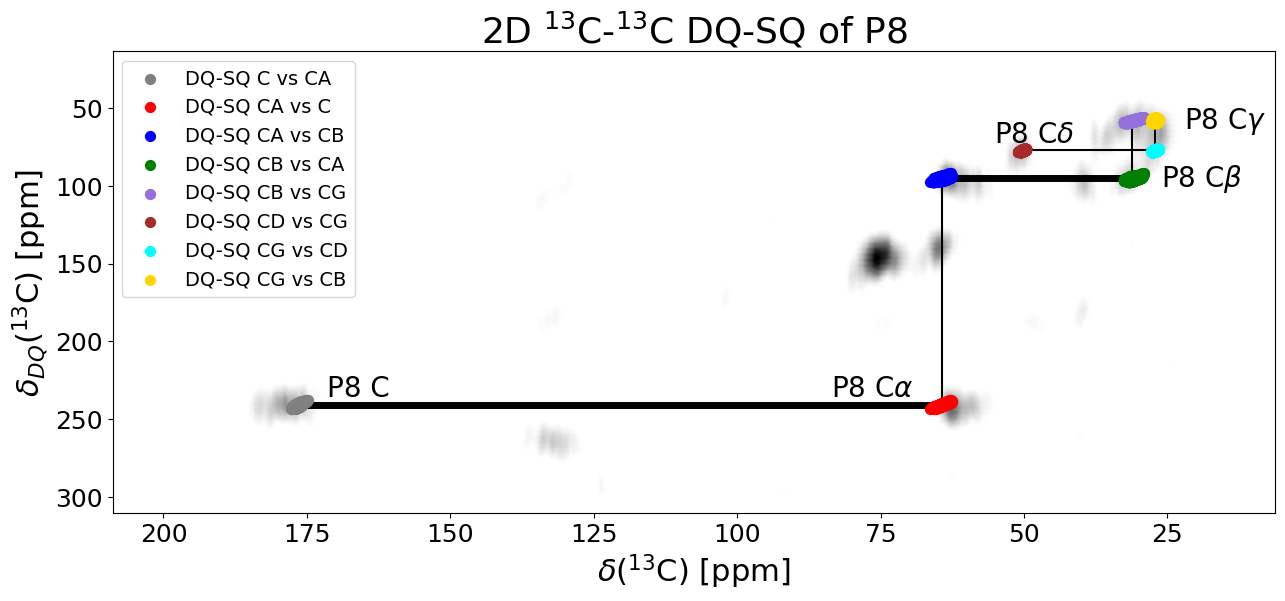

In [6]:
plot_dq_sq('Computational_data/CS_peptide_7EIB_2.csv','plots/DQ-SQ_pro8_replicate2.png')

#### Replicate 3

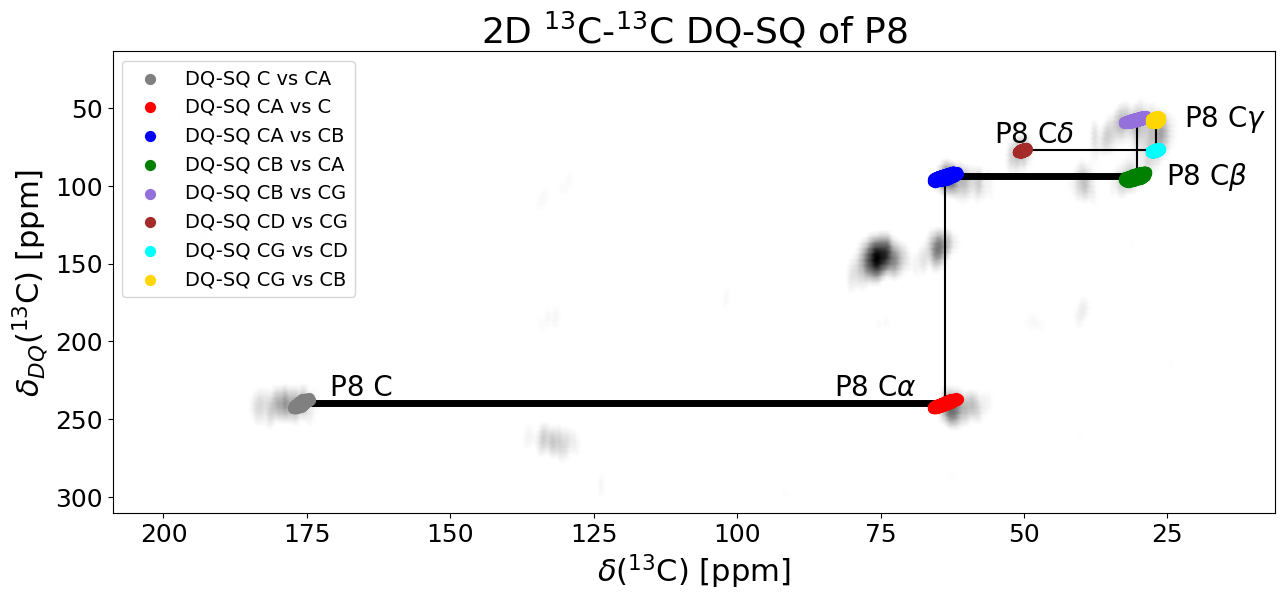

In [7]:
plot_dq_sq('Computational_data/CS_peptide_7EIB_3.csv','plots/DQ-SQ_pro8_replicate3.png')